# <font color='#4C5FDA'>**Breast Cancer Detection Based on CNNs Using Thermal Imaging** </font>

Original paper by Juan Pablo Zuluaga, Zeina Al Masry, Khaled Benaggoune, Safa Meraghni & Noureddine Zerhouni: [A CNN-based methodology for breast cancer diagnosis using thermal images](https://www.tandfonline.com/doi/full/10.1080/21681163.2020.1824685)

In [1]:
#@title **Importamos librerías necesarias**

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F

# PyTorch torchvision
from torchvision.transforms import v2

# Pytorch essentials for datasets.
from torch.utils.data import Dataset, DataLoader, ConcatDataset

# Data manipulation
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
# from PIL import Image

# Utils
from tqdm import tqdm
from datetime import datetime

## <font color='#ECA702'>**Configuración inicial para conectarnos con Kaggle**</font>

1. Instalamos kaggle. Para poder usar comandos de Kaggle.

In [2]:
! pip install kaggle

Subimos nuestro token de autenticación de Kaggle (si estamos en colab, sino colocarlo en la carpeta del proyecto)

In [ ]:
from google.colab import files
files.upload()

1. Creamos los directorios de Kaggle
2. Copiamos nuestro token en .kaggle
3. Con `chmod 600` establecemos los permitos del token en 600, es decir, que solo yo tengo permisos de lectura y escritura sobre el archivo

In [3]:
! mkdir ~/kaggle

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

## <font color='#ECA702'>**Procesamiento del dataset**</font>

### <font color='#52F17F'>**Carga del dataset**</font>

Traemos el dataset [Thermal Images for Breast Cancer Diagnosis DMR-IR](https://www.kaggle.com/datasets/asdeepak/thermal-images-for-breast-cancer-diagnosis-dmrir) desde kaggle.

This dataset is a methodology for breast disease computer-aided diagnosis using dynamic thermography. The thermal images for breast tumors are classified according to DMR-IR standards.

Two types of tumors are classified in this dataset one is benign another is malignant.
- Benign: This type of tumor is usually well-defined and round or oval in shape. (non-cancerous tumor)
- Malignant: This type of tumor is usually poorly defined and irregular with lobules. (cancerous tumor)

In [ ]:
! kaggle datasets download -d asdeepak/thermal-images-for-breast-cancer-diagnosis-dmrir
! unzip thermal-images-for-breast-cancer-diagnosis-dmrir.zip

Después de descargar los datos. Debemos entender la estructura de las carpetas para poder trabajar con ellas de una mejor manera.
1. La carpeta principal `Imagens e Matrizes da Tese de Thiago Alves Elias da Silva` son todos los datos `data`.
2. La carpeta `12 Novos Casos de Testes` la podemos tomar como nuestro conjunto de prueba (`test`).
3. Mientras que la carpeta `Desenvolvimento da Metodologia` será nuestro conjunto de entrenamiento (`train`).

Luego dentro de nuestras carpetas de `train` y `test` encontramos dos categorías `DOENTES`y `SAUDAтХа├╝VEIS` o SAUDÁVEI. Los primeros son los casos malignos y los segundos benignos.

Dentro de cada una de las carpetas de pacientes saludables y enfermos se encuentran carpetas con números, cada número representa un paciente. Y para cada paciente tendremos dos carpetas más, una para las imágenes **segmentadas** en escala de grises y la otra para la matrix o mapa de calor.

Algo bueno de este dataset es que ya está dividido por pacientes, es decir, no tendremos imagenes del mismo paciente en el conjunto de entrenamiento y testeo. Por lo tanto, vamos a entrenar con N pacientes, y testear con K pacientes, que no son los mismos.

### <font color='#52F17F'>**Preprocesamiento de los datos**</font>

#### <font color="6600CC">**Ejemplo con un sample**</font>

In [19]:
matrix = np.loadtxt("Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Matrizes/PAC_62_DN0.txt", dtype=np.float32)
print(matrix.shape)
print(matrix.max(), matrix.min())

(480, 640)
36.22 21.07


In [20]:
matrix = np.loadtxt("Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Matrizes/PAC_62_DN1.txt", dtype=np.float32)
print(matrix.shape)
print(matrix.max(), matrix.min())

(480, 640)
35.98 21.05


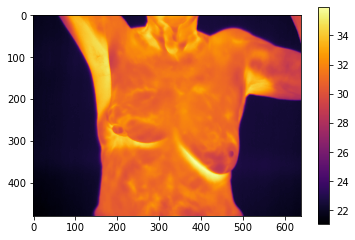

In [21]:
plt.imshow(matrix, cmap="inferno")
plt.colorbar()
plt.show()

In [22]:
img_gray = cv2.imread("Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Segmentadas/PAC_62_DN0-dir.png", cv2.IMREAD_GRAYSCALE)
print(img_gray.shape, img_gray.dtype, img_gray.min(), img_gray.max())

(480, 640) uint8 0 222


In [23]:
segmented = np.where(img_gray==0, 0, 1)
segmented = matrix * segmented
print(segmented.shape, segmented.dtype, segmented.min(), segmented.max())

(480, 640) float64 0.0 34.400001525878906


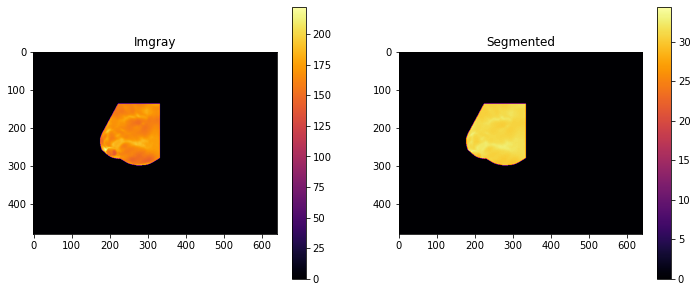

In [24]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title("Imgray")
plt.imshow(img_gray, cmap="inferno")
plt.colorbar()
plt.subplot(122)
plt.title("Segmented")
plt.imshow(segmented, cmap="inferno")
plt.colorbar()
plt.show()

#### <font color="6600CC">**Haciendo el cropp**</font>

In [25]:
def crop_breast(img):
  img_copy = img.copy().astype('uint8')

  # Crear un binario invertido de la imagen
  _, thresh = cv2.threshold(img_copy, 1, 255, cv2.THRESH_BINARY)

  # Encontrar contornos
  contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Si no se encuentran contornos, retornar la imagen original
  if not contours:
    return img

  # Encontrar el rectángulo delimitador que contiene el objeto
  x, y, w, h = cv2.boundingRect(contours[0])

  # Recortar la imagen utilizando el rectángulo delimitador
  cropped_image = img[y:y+h, x:x+w]

  return cropped_image

In [26]:
img_cropped = crop_breast(segmented)
print(img_cropped.dtype, img_cropped.shape, img_cropped.max(), img_cropped.min())
print(segmented.shape, segmented.dtype, segmented.max(), segmented.min())

float64 (162, 157) 34.400001525878906 0.0
(480, 640) float64 34.400001525878906 0.0


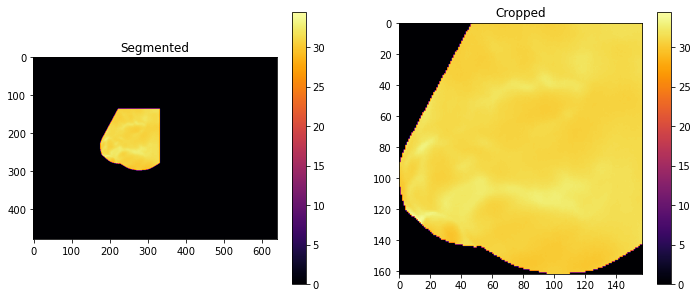

In [27]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title("Segmented")
plt.imshow(segmented, cmap="inferno")
plt.colorbar()
plt.subplot(122)
plt.title("Cropped")
plt.imshow(img_cropped, cmap="inferno")
plt.colorbar()
plt.show()

¿Qué pasa si le hago resize? ¿Qué tamaño conviene? https://medium.com/analytics-vidhya/how-to-pick-the-optimal-image-size-for-training-convolution-neural-network-65702b880f05

In [28]:
img_cropped_resized = cv2.resize(img_cropped, (112, 112))
print(img_cropped_resized.dtype, img_cropped_resized.shape, img_cropped_resized.max(), img_cropped_resized.min())

float64 (112, 112) 33.875654990575754 0.0


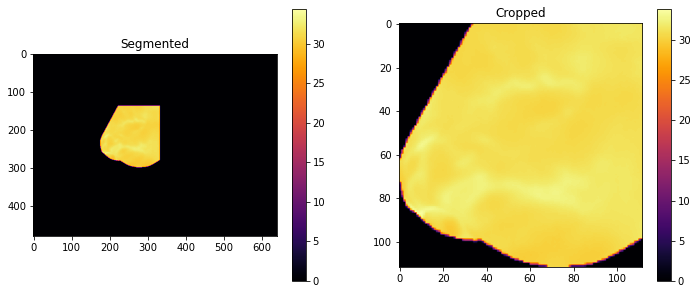

In [29]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title("Segmented")
plt.imshow(segmented, cmap="inferno")
plt.colorbar()
plt.subplot(122)
plt.title("Cropped")
plt.imshow(img_cropped_resized, cmap="inferno")
plt.colorbar()
plt.show()

!!! https://stackoverflow.com/questions/44409981/how-to-convert-between-different-color-maps-on-opencv

#### <font color="6600CC">**Ecualización del histograma y normalización (no va)**</font>

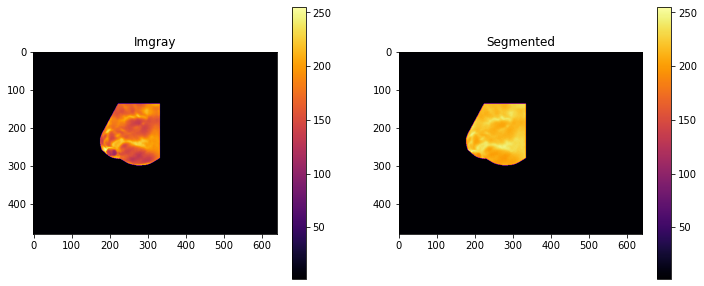

In [30]:
# Create an object for executing CLAHE.
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

""" Para la imgray """

# Normalizing frame to range [0, 255], and get the result as type uint8.
normed = cv2.normalize(img_gray, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
# Apply CLAHE - contrast enhancement.
cl1 = clahe.apply(normed)

""" Para la segmented """

# Normalizing frame to range [0, 255], and get the result as type uint8.
normed = cv2.normalize(segmented, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
# Apply CLAHE - contrast enhancement.
cl2 = clahe.apply(normed)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title("Imgray")
plt.imshow(cl1, cmap="inferno")
plt.colorbar()
plt.subplot(122)
plt.title("Segmented")
plt.imshow(cl2, cmap="inferno")
plt.colorbar()
plt.show()

#### <font color="6600CC">**Detalle con las imágenes segmentadas**</font>

In [31]:
# La primera la lee en RGB, pero la original viene con 4 canales
img_der = cv2.imread("Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Segmentadas/PAC_62_DN0-dir.png")

# # https://stackoverflow.com/questions/3803888/how-to-load-png-images-with-4-channels
img_original = cv2.imread("Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Segmentadas/PAC_62_DN0-dir.png", cv2.IMREAD_UNCHANGED)

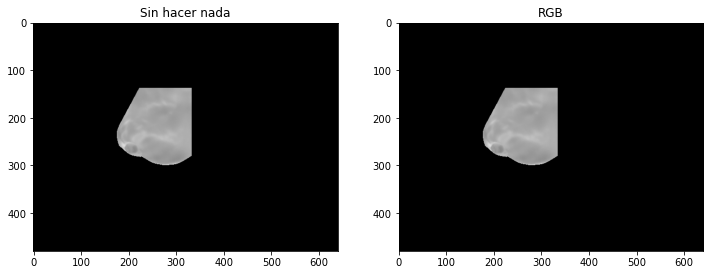

In [32]:
plt.figure(figsize=(12,9))
plt.subplot(121)
plt.title("Sin hacer nada")
plt.imshow(img_original)
plt.subplot(122)
plt.title("RGB")
plt.imshow(img_der)
plt.show()

¿Por qué las segmentadas vienen en 4 canales? ¿Cómo interpretar el cuarto canal?

In [33]:
img_original[:, :, 3]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

### <font color='#52F17F'>**Creación del Dataset PyTorch**</font>

¿Qué es?: https://youtu.be/jF43_wj_DCQ?list=PL_lsbAsL_o2CTlGHgMxNrKhzP97BaG9ZN&t=53

In [2]:
"""
Constante encontrada al iterar por todas las imágenes segmentadas, 
calcular su valor máximo de temperatura y devolver el máximo de todas.
"""

MAX_TEMPERATURE = 36.44

In [4]:
class ThermalDataset(Dataset):
  def __init__(self, image_dir: str, matrix_dir: str, transform = None, normalize = None):
    self.image_dir = image_dir
    self.matrix_dir = matrix_dir
    self.transform = transform
    self.normalize = normalize
    self.images = os.listdir(image_dir) # Listamos todas las imagenes en la carpeta

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):

    """ Carga de la imagen """

    # Entramos a la carpeta y conseguimos la imagen de la lista
    img_path = os.path.join(self.image_dir, self.images[index])

    # Leemos la imagen segmentada en escala de grises
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # uint8
    # img = Image.open(img_path)


    """ Carga de la matrix """

    # Entramos a la carpeta y conseguimos la matrix de la lista.
      # La razon por la que uso la misma lista de imagenes es porque la imagen y la matrix
      # tienen el mismo nombre, solo cambia la ruta de la carpeta y la extensión.
    """ matrizes: Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Matrizes/PAC_62_DN0.txt """
    """ segmentada: Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Segmentadas/PAC_62_DN0-dir.png """
    
    if '-dir.png' in self.images[index]:
      matrix_path = os.path.join(self.matrix_dir, self.images[index].replace("-dir.png", ".txt"))
    elif '-esq.png' in self.images[index]:
      matrix_path = os.path.join(self.matrix_dir, self.images[index].replace("-esq.png", ".txt"))
      
    matrix = np.loadtxt(matrix_path, dtype=np.float32) # https://www.geeksforgeeks.org/import-text-files-into-numpy-arrays/

    """ Consigo la imagen segmentada con los valores de la matrix """

    segmented = np.where(img==0, 0, 1) # int64
    # segmented = img * matrix
    img = (matrix * segmented).astype(np.float32) # float32, shape (480, 640)

    # Le agrego un canal explícito 
    img = np.expand_dims(img, axis=2) # https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html

    if self.normalize:
      img = img / MAX_TEMPERATURE

    """ Consiguiendo el label """

    # Para conseguir la etiqueta simplemente me tengo que fijar en la ruta. Si es 'DOENTES' 1
    # sino 0.

    label = self.image_dir.split('/')[2]
    if label == 'DOENTES':
      label = 1
    else:
      label = 0

    """ Convertir las imagenes en tensores y hacer resize """
    if self.transform:
      # Aplicamos las transformaciones a la imagen
      # print(type(img), img.shape)
      img = self.transform(img)
      
    return img, label

In [5]:
TEST_PATH = "Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes"
TRAIN_PATH = "Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia"

In [6]:
# Primero consigo la ruta de imagenes y matrices para cada uno de los pacientes

dirs_test = []
test_images = 0
test_matrices = 0
for category in os.listdir(TEST_PATH):
  # print(category)
  for patient in os.listdir(os.path.join(TEST_PATH, category)):
    # print(os.path.join(TEST_PATH, category, patient))
    dirs_test.append(os.path.join(TEST_PATH, category, patient))
    _, _, files = next(os.walk(os.path.join(TEST_PATH, category, patient, "Segmentadas")))
    # print(files)
    test_images += len(files)
    _, _, files = next(os.walk(os.path.join(TEST_PATH, category, patient, "Matrizes")))
    test_matrices += len(files)


dirs_train = []
train_images = 0
train_matrices = 0
for category in os.listdir(TRAIN_PATH):
  # print(category)
  for patient in os.listdir(os.path.join(TRAIN_PATH, category)):
    # print(os.path.join(TRAIN_PATH, category, patient))
    dirs_train.append(os.path.join(TRAIN_PATH, category, patient))
    _, _, files = next(os.walk(os.path.join(TRAIN_PATH, category, patient, "Segmentadas")))
    train_images += len(files)
    try:
      _, _, files = next(os.walk(os.path.join(TRAIN_PATH, category, patient, "Matrizes")))
      train_matrices += len(files)
    except:
      _, _, files = next(os.walk(os.path.join(TRAIN_PATH, category, patient, "Matrizes de Temperatura")))
      train_matrices += len(files)



# Imprimo la cantidad de pacientes y datos que tenemos
print(f"Cantidad de pacientes para testeo: {len(dirs_test)}")
print(f"Cantidad de imagenes para testeo: {test_images}")
print(f"Cantidad de matrices para testeo: {test_matrices}")
print()
print(f"Cantidad de pacientes para entrenamiento: {len(dirs_train)}")
print(f"Cantidad de imagenes para entrenamiento: {train_images}")
print(f"Cantidad de matrices para entrenamiento: {train_matrices}")

Cantidad de pacientes para testeo: 9
Cantidad de imagenes para testeo: 240
Cantidad de matrices para testeo: 180

Cantidad de pacientes para entrenamiento: 47
Cantidad de imagenes para entrenamiento: 1282
Cantidad de matrices para entrenamiento: 948


En teoría por cada paciente tenemos 20 imagenes, pero las cuentas no cuadran, por ejemplo en testeo deberíamos tener 9x20 = 180 imagenes, pero aparecen 240. Esto sucede debido a que hay algunas imagenes que están separadas en la parte izquierda y derecha.

Para el conjunto de entrenamiento tampoco cuadra el número de matrices. Esto es debido a que algunos pacientes tienen una matriz que se llama `ESTATICO` que no tengo ni idea para qué es pero no es problema ya que no hace 'match' con ninguna imágen.

In [7]:
matrix = np.loadtxt("Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/DOENTES/245/Matrizes/PAC_26_ESTATICO.txt", dtype=np.float32)
print(matrix.shape)
print(matrix.max(), matrix.min())

(480, 640)
35.02 20.38


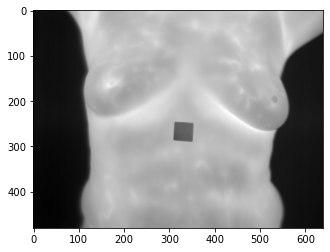

In [8]:
plt.imshow(matrix, cmap='gray')
plt.show()

In [9]:
# Todas las imagenes vienen en h: 480, w: 640. El objetivo es disminuir el tamaño
# sin perder la relación de aspecto. https://gist.github.com/tomvon/ae288482869b495201a0

HEIGHT = 300
r = HEIGHT/480 # Calculo la relación de aspecto. 
WIDTH = int(640*r)
# print(f"Las imagenes son reescaladas a {HEIGHT}x{WIDTH}")

# https://pytorch.org/vision/main/transforms.html#performance-considerations
transform = v2.Compose([  
    v2.ToImage(), 
    # v2.Resize(size=(HEIGHT, WIDTH), antialias=True), 
    # v2.ToDtype(torch.float32),
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Para cada paciente armo un dataset y luego con `ConcatDataset` junto todos los pacientes para entrenamiento y para testeo.

In [10]:
test_datasets = []
for patient in dirs_test:
  folders = sorted(os.listdir(patient))
  # print(folders)
  test_datasets.append(ThermalDataset(f"{patient}/{folders[1]}", f"{patient}/{folders[0]}", transform=transform))

In [11]:
train_datasets = []
for patient in dirs_train:
  folders = sorted(os.listdir(patient))
  # print(folders)
  train_datasets.append(ThermalDataset(f"{patient}/{folders[1]}", f"{patient}/{folders[0]}", transform=transform))

In [12]:
# Datasets (concatenate) https://stackoverflow.com/questions/60840500/pytorch-concatenating-datasets-before-using-dataloader
test_dataset = ConcatDataset(test_datasets)
train_dataset = ConcatDataset(train_datasets)

In [13]:
print(test_dataset[4][0].shape, type(test_dataset[4][1]))

torch.Size([1, 480, 640]) <class 'int'>


libpng warning: bKGD: invalid
libpng warning: bKGD: invalid


#### <font color="6600CC">**Consiguiendo la temperatura máxima de todas las imágenes segmentadas**</font>

In [24]:
full_dataset = ConcatDataset([test_dataset, train_dataset])
MAX_TEMPERATURE = 0
for record in full_dataset:
  max_temperature_record = record[0].numpy().max()
  # print(max_temperature_record)
  if max_temperature_record > MAX_TEMPERATURE:
    MAX_TEMPERATURE = max_temperature_record
    print(MAX_TEMPERATURE)

32.05
33.09
33.27


libpng warning: bKGD: invalid
libpng warning: bKGD: invalid


33.36


libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid


33.41


libpng warning: bKGD: invalid
libpng warning: bKGD: invalid


34.11
34.22
34.57
35.23
35.29
35.48
35.86
36.23
36.44


In [25]:
print(MAX_TEMPERATURE)

36.44


### <font color='#52F17F'>**Visualización de datos**</font>

In [14]:
def visualize_data(dataset, rows=3, cols=3):
    """
    Visualiza aleatoriamente imágenes del dataset junto con sus etiquetas.

    Args:
        dataset (list): Lista de tuplas donde cada tupla contiene una imagen y su etiqueta correspondiente.
                        La imagen es un arreglo numpy y la etiqueta es un entero (0 para Benign, 1 para Malignant).
        rows (int): Número de filas en la cuadrícula de visualización.
        cols (int): Número de columnas en la cuadrícula de visualización.

    Returns:
        None: Muestra una figura con las imágenes y etiquetas del dataset.
    """
    plt.figure(figsize=(20, rows * 4))
    breast_types = {0: 'Benign', 1: 'Malignant'}

    # Seleccionar índices aleatorios del dataset
    indices = np.random.choice(len(dataset), rows * cols, replace=False)

    for i, idx in enumerate(indices, start=1):
        img = dataset[idx][0].squeeze(0) # Extraer la imagen y eliminar dimensiones singleton si es necesario
        label = dataset[idx][1] # Extraer la etiqueta

        # Configurar la posición del subplot
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap='inferno')
        plt.title(f"{breast_types[label]}")
        plt.colorbar()
    plt.show()

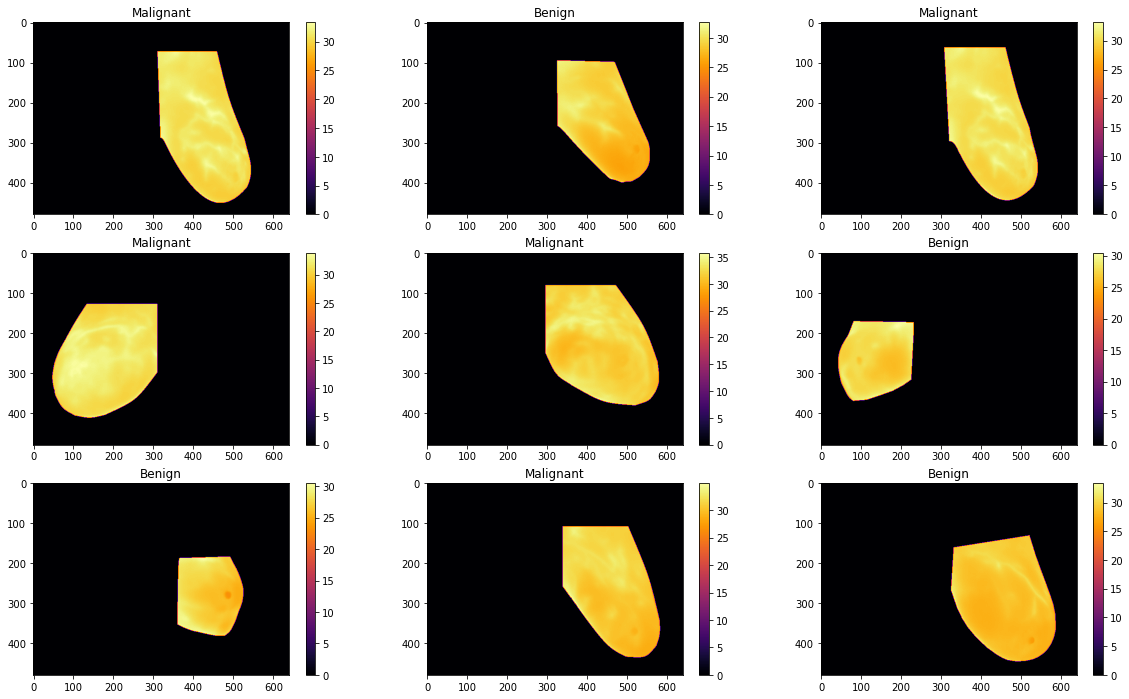

In [15]:
visualize_data(train_dataset)

## <font color='#ECA702'>**Modelo CNN**</font>

### <font color='#52F17F'>**Creando el modelo**</font>

In [51]:
# Este el modelo de ejemplo que usan aquí: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Los parametros de esta capa dependen de la salida de la convolución anterior
        self.fc1 = nn.Linear(16 * 117 * 157, 120)
        self.fc2 = nn.Linear(120, 84)

        # El 2 es porque tenemos dos clases y vamos a usar Cross Entropy Loss
        self.fc3 = nn.Linear(84, 2) 
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [52]:
# Test al modelo, para ver si nos entrega la salida esperada

input_image = train_dataset[0][0].unsqueeze(0)
print(f"Entrada: {input_image.size(), {input_image.dtype}}")
model = Net()
ouput = model(input_image)
print(f"Salida: {ouput.size(), ouput.dtype}") # Esperado: [1, 2] (batch 1, 2 clases)

Entrada: (torch.Size([1, 1, 480, 640]), {torch.float32})
Salida: (torch.Size([1, 2]), torch.float32)


### <font color='#52F17F'>**Entrenamiento del modelo**</font>

In [54]:
# Hiperparametros
LEARNING_RATE = 1e-4
# Establecemos el tipo de arquitectura que va a entrenar el modelo.
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4

In [55]:
# Datasets
test_datasets = []
for patient in dirs_test:
  folders = sorted(os.listdir(patient))
  # print(folders)
  test_datasets.append(ThermalDataset(f"{patient}/{folders[1]}", f"{patient}/{folders[0]}", transform=transform, normalize=True))

train_datasets = []
for patient in dirs_train:
  folders = sorted(os.listdir(patient))
  # print(folders)
  train_datasets.append(ThermalDataset(f"{patient}/{folders[1]}", f"{patient}/{folders[0]}", transform=transform, normalize=True))

test_dataset = ConcatDataset(test_datasets)
train_dataset = ConcatDataset(train_datasets)

# Dataloaders
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=True)
print(f'len train: {len(train_loader)}')
print(f'len val: {len(test_loader)}')

len train: 321
len val: 60


In [56]:
""" Parametros del modelo """

# Creacion del modelo y lo movemos a la GPU o CPU
model = Net()
model.to(DEVICE)

# Funcion de perdida (loss)
criterion = nn.CrossEntropyLoss()

# Algoritmos de optimización del gradiente. DESPUÉS de mover el modelo a la GPU.
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [57]:
""" Para guardar datos del modelo cada vez que cambiemos los parametros """

# Se inicializa en una celda separada, así podemos añadir facilmente epocas al mismo run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Crear la carpeta models por si no existe
if os.path.exists('models') == False:
    os.mkdir("models")
    
model_folder_path = f'models/breast_model_{timestamp}'
# model_folder = os.mkdir(model_folder_path)
epoch_number = 0

In [58]:
EPOCHS = 5

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    print(f"EPOCH {epoch_number + 1}")

    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Movemos los datos al device
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        # print(ouputs.dtype)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'batch {i + 1:5d} loss: {running_loss / 100:.3f}')
            running_loss = 0.0
    epoch_number += 1 # Pasamos a la siguiente época
print('Finished Training')

EPOCH 1


0it [00:00, ?it/s]

101it [00:16,  7.43it/s]

batch   100 loss: 0.580


201it [00:29,  7.60it/s]

batch   200 loss: 0.412


301it [00:43,  7.44it/s]

batch   300 loss: 0.385


321it [00:45,  6.99it/s]


EPOCH 2


101it [00:13,  7.10it/s]

batch   100 loss: 0.293


200it [00:49,  3.51it/s]

batch   200 loss: 0.242


300it [01:17,  3.40it/s]

batch   300 loss: 0.170


321it [01:23,  3.84it/s]


EPOCH 3


100it [00:28,  3.57it/s]

batch   100 loss: 0.124


200it [00:57,  3.50it/s]

batch   200 loss: 0.142


300it [01:26,  3.34it/s]

batch   300 loss: 0.132


321it [01:32,  3.48it/s]


EPOCH 4


100it [00:28,  3.47it/s]

batch   100 loss: 0.143


200it [00:57,  3.45it/s]

batch   200 loss: 0.085


300it [01:26,  3.51it/s]

batch   300 loss: 0.060


321it [01:32,  3.47it/s]


EPOCH 5


100it [00:28,  3.48it/s]

batch   100 loss: 0.045


200it [00:57,  3.48it/s]

batch   200 loss: 0.047


300it [01:26,  3.39it/s]

batch   300 loss: 0.053


321it [01:32,  3.47it/s]

Finished Training


### <font color='#52F17F'>**Guardar el modelo**</font>

In [59]:
def save_checkpoint(state, filename=f'model_{timestamp}.pth'):
  print("=> Saving model")
  torch.save(state, filename)
  print("Model saved in", filename)

In [60]:
# Establecemos la ruta donde se va a guardar el estado del modelo
model_path = f"{model_folder_path}_{epoch_number}.pth"

# Guardamos el estado del modelo
checkpoint = {'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'epoch': epoch_number + 1}

save_checkpoint(checkpoint, model_path)

=> Saving model
Model saved in models/breast_model_20240525_135427_5.pth


## <font color='#ECA702'>**Evaluación del modelo**</font>

### <font color='#52F17F'>**Carga un modelo para hacer inferencia o conseguir sus métricas.**</font>

In [62]:
print('=> Loading model')
checkpoint = torch.load("models/breast_model_20240525_135427_5.pth") # Ruta donde está el modelo

# Si el diccionario tiene la clave 'state_dict', significa que NO viene solo el modelo
if 'state_dict' in checkpoint:
  model.load_state_dict(checkpoint['state_dict'])
  print("Modelo cargado exitosamente.")
else:
  # Si viene solo el modelo
  model.load_state_dict(checkpoint)

model.to(DEVICE)
# Apagamos el modo entrenamiento. Es equivalente a model.train(False)
model.eval()
# Para verificar si mi modelo NO está en modo entrenamiento
if not model.training:
    print('El modelo ha sido cargado con training off exitosamente.')

=> Loading model
Modelo cargado exitosamente.
El modelo ha sido cargado con training off exitosamente.


### <font color='#52F17F'>**Display any images from test for inference**</font>

In [63]:
def visualize_images(testloader, rows=3, cols=3):
    """
    Visualiza imágenes de un tensor junto con sus etiquetas.

    Args:
        images (torch.Tensor): Tensor de imágenes de tamaño [N, C, H, W].
        labels (torch.Tensor): Tensor de etiquetas correspondiente a las imágenes.
        rows (int): Número de filas en la cuadrícula de visualización.
        cols (int): Número de columnas en la cuadrícula de visualización.

    Returns:
        None: Muestra una figura con las imágenes y sus etiquetas.
    """

    dataiter = iter(testloader)
    images, labels = next(dataiter)

    plt.figure(figsize=(30, rows * 4))
    breast_types = {0: 'Benign', 1: 'Malignant'}

    # Seleccionar índices aleatorios del tensor
    indices = np.random.choice(images.shape[0], rows * cols, replace=False)

    for i, idx in enumerate(indices, start=1):
        img = images[idx].squeeze(0).numpy()  # Extraer la imagen y eliminar dimensiones singleton si es necesario
        label = labels[idx].item()  # Extraer la etiqueta y convertir a entero

        # Configurar la posición del subplot
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap='inferno')
        plt.title(f"{breast_types[label]}")
        plt.colorbar()
    plt.show()
    del dataiter
    return images, labels

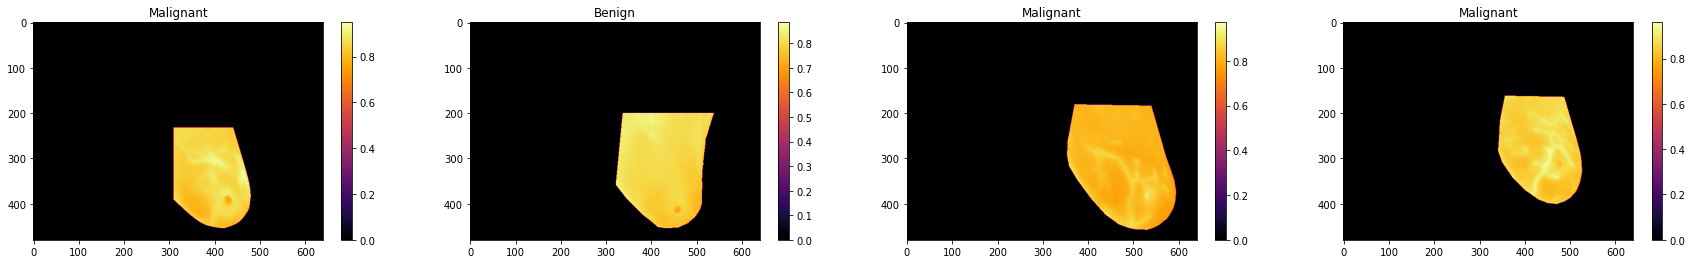

In [64]:
images, labels = visualize_images(test_loader, rows=1, cols=4)

In [65]:
classes = ('Benign', 'Malignant')

images, labels = images.to(DEVICE), labels.to(DEVICE)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  Benign Benign Benign Benign


### <font color='#52F17F'>**Métricas del modelo**</font>

In [66]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {test_images} test images: {100 * correct // total} %')


libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid


Accuracy of the network on the 240 test images: 44 %


Ni idea qué sea `libpng warning: bKGD: invalid`.  **Solo pasa con la de test**

**ChatGPT**: Los warnings libpng warning: bKGD: invalid indican que las imágenes que estás utilizando en tu código contienen información de fondo (background) inválida o malformada en sus metadatos. Estos warnings son emitidos por la biblioteca libpng cuando intenta procesar imágenes PNG con campos de metadatos no estándar o incorrectos.

Posibles Soluciones

- Ignorar los Warnings:
Si los warnings no están afectando tu procesamiento, puedes optar por ignorarlos. En muchos casos, estos warnings no impiden que las imágenes se procesen correctamente.

- Limpiar los Metadatos de las Imágenes: Puedes limpiar los metadatos de las imágenes PNG para eliminar cualquier información inválida. ¿Cómo? Convirtiendo las imágenes a otro formato o abriendolas y guardandolas con el mismo formato.